In [1]:
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from itertools import chain
from PLAB.utils import gini_coefficient

Read in count data.

In [2]:
file_sample_names = ['liquid', 'semisolid', 'small_plate','large_plate', 'bead', 'input']
names_dict = {'liquid': 'liquid', 'semisolid': 'semisolid', 'small_plate': 'high density spread', 'bead': 'bead spread', 'large_plate': 'low density spread', 'input': 'input'}
sample_names = [names_dict[name] for name in file_sample_names]
counts = []

for sample in file_sample_names:
  for replicate in range(1, 5):
    with open(f'../../data/20240318_counts/MORF_counts_20240318/{sample}_{replicate}.pkl', 'rb') as f:
      clusters = pickle.load(f)
      for center in clusters:
        counts.append((names_dict[sample], replicate, center, clusters[center].total()))

count_df = pd.DataFrame(counts, columns=['sample', 'replicate', 'sequence', 'count'])
count_df.head()

,sample,replicate,sequence,count
0,liquid,1,TAGTTGGGAAGGAGAATTCATCTT,850
1,liquid,1,TCAGAACGCATTGTAACGCAAGGC,721
2,liquid,1,GCATGGGCTAGTTGAGCATTTGTG,717
3,liquid,1,GGGATGTAGTGATACACATCATAA,650
4,liquid,1,TTGAAGTACCTTATATGCTATATC,629


Read in MORF library data.

In [3]:
MORF_df = pd.read_csv('200102_tf_orf_library.csv')
MORF_df.head()

,Name,RefSeq Gene Name,RefSeq and Gencode ID,Barcode Sequence,ORF sequence,Full sequence,Notes 1,Notes 2
0,TFORF0001,HIF3A,"NM_022462,ENST00000244303",AGTCAAGACCCTCGGGCTCTGTGG,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
1,TFORF0002,HIF3A,"NM_152796,ENST00000472815",CAATTACACCACGTCTGCCTACTA,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
2,TFORF0003,HIF3A,"NM_152794,ENST00000300862",TTCAGACGTTTCGCGCCTGGAGCT,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
3,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",GATAACGCTAACCACAAGGTATTT,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
4,TFORF0005,HIF3A,"NM_152795,ENST00000377670",CCACGCGAGCTAGACGATCGATGA,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN


Some of the clustered barcodes may not exactly match the expected barcode sequences if there were only a few reads and some had errors in them. For any sequence cluster that doesn't match an expected barcode, try to match it to an expected barcode, and if there is no match then throw it out.

First see what the minimum distance between barcodes is.

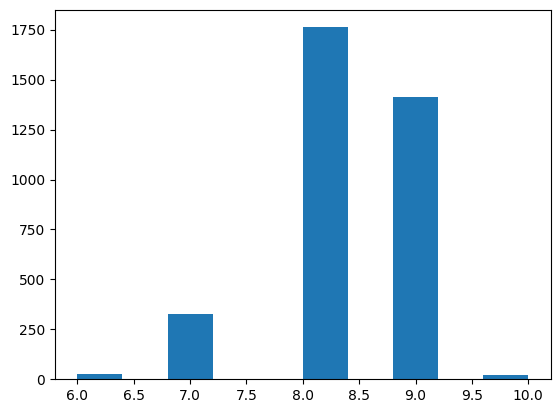

In [4]:
all_bcs = list(MORF_df['Barcode Sequence'])
min_dists = []
for i, bc1 in enumerate(all_bcs):
  min_dist = 100
  for j, bc2 in enumerate(all_bcs):
    if i != j:
      dist = Levenshtein.distance(bc1, bc2)
      if dist < min_dist:
        min_dist = dist
  min_dists.append(min_dist)
plt.hist(min_dists)
plt.show()

For each cluster sequence, check whether it exists in the list of expected barcodes. If not, then find the closest one and save the barcode sequence and its distance to the cluster sequence.

In [5]:
all_bcs_set = set(all_bcs)

def get_bc(bc):
  if bc in all_bcs_set:
    return (bc, 0)
  else:
    min_dist = 100
    for i, bc2 in enumerate(all_bcs):
      dist = Levenshtein.distance(bc, bc2)
      if dist < min_dist:
        min_dist = dist
        min_bc = bc2
    return (min_bc, min_dist)
  
count_df[['barcode', 'distance']] = count_df.apply(lambda row: get_bc(row['sequence']), axis='columns', result_type='expand')
count_df['distance'].value_counts()

0    84049
8      117
7       71
9       53
4        8
5        5
1        4
6        1
Name: distance, dtype: int64

In [6]:
count_df[(count_df['distance'] < 6) & (count_df['distance'] > 0)]

,sample,replicate,sequence,count,barcode,distance
3495,liquid,1,GAGATCACTTAACGCGTCGATGAG,1,GAGATCACTTAACGCGCCTCATCG,5
10543,liquid,3,GATTCGCGTCACCTAATTAGAGGG,1,GATTCGCGTCCCTCTAATTAGGTG,4
14054,liquid,4,GATTCGCGTCACCTAATTAGAGGG,1,GATTCGCGTCCCTCTAATTAGGTG,4
17574,semisolid,1,TCCATTGCCCGAGTCTATGGATGA,1,GCTAGTACCCGAGTCTATGGATGA,4
21085,semisolid,2,TTGTGGTGTGGGCAGTTTGGCCAC,1,TTGTGGTGTGGCCAAACTGCCCAC,5
28122,semisolid,4,AAACTCGCGTCCCGAATTTACGCG,1,AAACTCGCGTCGCGTAAATTCGGG,5
28127,semisolid,4,CTACTCGACCAGAAACGCGTGCAT,1,CTACTCGACCAGAAACGCGTATGC,4
35122,high density spread,2,GACGCGTGATCCCAGCATGTACCT,2,GACGTGTGATCCCAGCATGTACCT,1
35139,high density spread,2,TAACATCTGCCATCCCGCGCGAGC,1,TAACATCTGCCATCCCACGCGAGC,1
42145,high density spread,4,AGGTCGTCCTTTGAATTGCCATGA,1,CCTACGTCCTTTGAATTGCCATGA,4


There are very few examples where the sequenced barcode doesn't match an expected barcode but is close (distance < 6) to one, and these examples are spread pretty evenly across the different conditions, so it's not worth keeping them as they will not affect the analysis in any significant way.

Merge the count dataframe with the MORF info dataframe, keeping only sequences that exactly match a barcode in the MORF library.

In [7]:
merged_df = pd.merge(count_df, MORF_df[['Barcode Sequence', 'Name', 'ORF sequence']], left_on='sequence', right_on='Barcode Sequence', how='inner')
merged_df['ORF length'] = merged_df['ORF sequence'].apply(len)
merged_df = merged_df[['sample', 'replicate', 'sequence', 'count', 'Name', 'ORF length']]
merged_df.head()

,sample,replicate,sequence,count,Name,ORF length
0,liquid,1,TAGTTGGGAAGGAGAATTCATCTT,850,TFORF2750,1101
1,liquid,2,TAGTTGGGAAGGAGAATTCATCTT,852,TFORF2750,1101
2,liquid,3,TAGTTGGGAAGGAGAATTCATCTT,850,TFORF2750,1101
3,liquid,4,TAGTTGGGAAGGAGAATTCATCTT,842,TFORF2750,1101
4,semisolid,1,TAGTTGGGAAGGAGAATTCATCTT,844,TFORF2750,1101


Calculate various statistics for each sample and plot them.

In [8]:
sample_stats = []
for rep in range(1, 5):
  for sample in sample_names:
    sample_counts = merged_df.loc[(merged_df['replicate'] == rep) & (merged_df['sample'] == sample)]['count']
    nobs, minmax, mean, var, skew, kurtosis = stats.describe(sample_counts)
    reads = sample_counts.sum()
    gini = gini_coefficient(np.array(sample_counts))
    median = np.median(sample_counts)
    stdev = np.std(sample_counts)
    sample_stats.append((sample, rep, nobs, reads, minmax[1], mean, median, stdev, skew, kurtosis, gini))
sample_stats_df = pd.DataFrame(sample_stats, columns=['sample', 'rep', 'unique seqs', 'reads', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis', 'gini']).melt(id_vars=['sample', 'rep'])

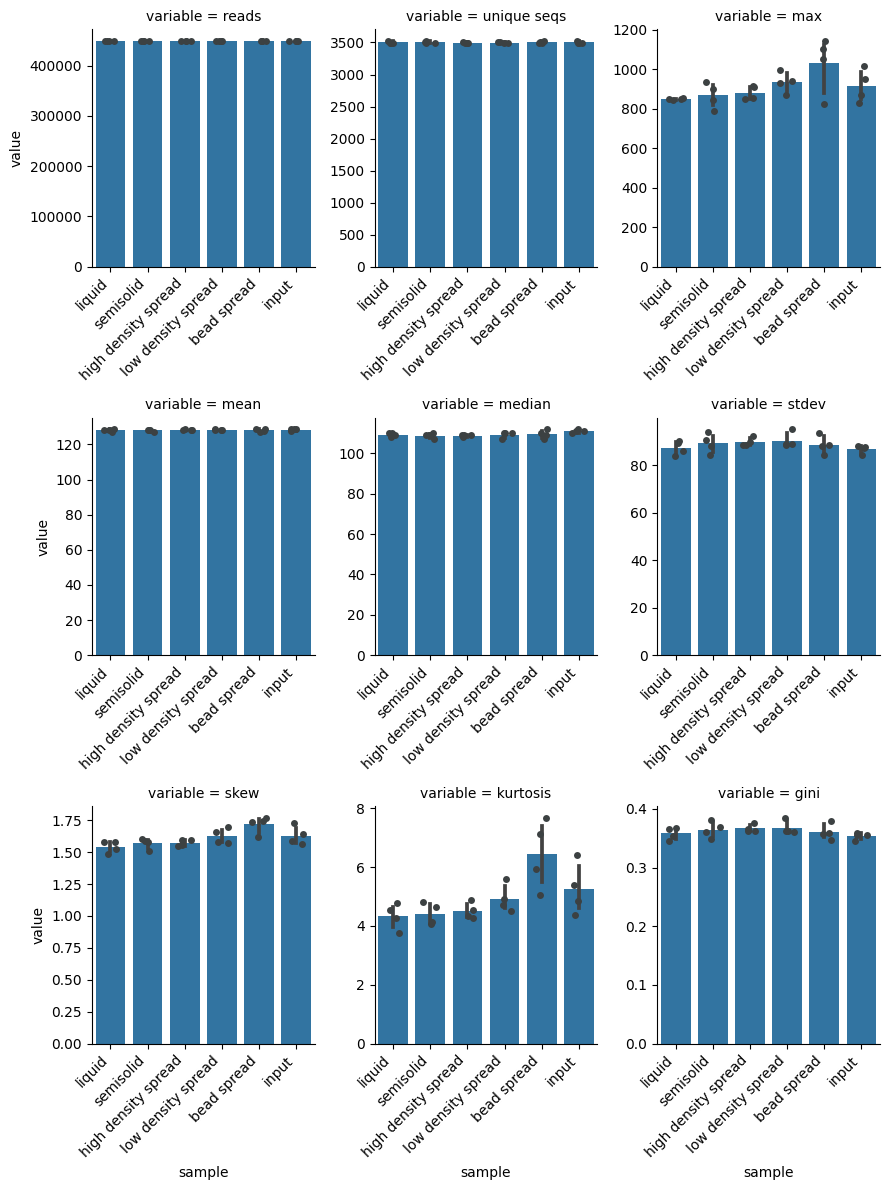

In [16]:
g = sns.FacetGrid(sample_stats_df, col='variable',
                  col_order=['reads', 'unique seqs', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis', 'gini'],
                  col_wrap=3, height=4, aspect=0.75, sharex=False, sharey=False)
g.map(sns.barplot, 'sample', 'value', order=sample_names)
g.map(sns.stripplot, 'sample', 'value', order=sample_names, color='#3c4142', size=5, jitter=0.2)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

Plot the distribution of counts for each sample.

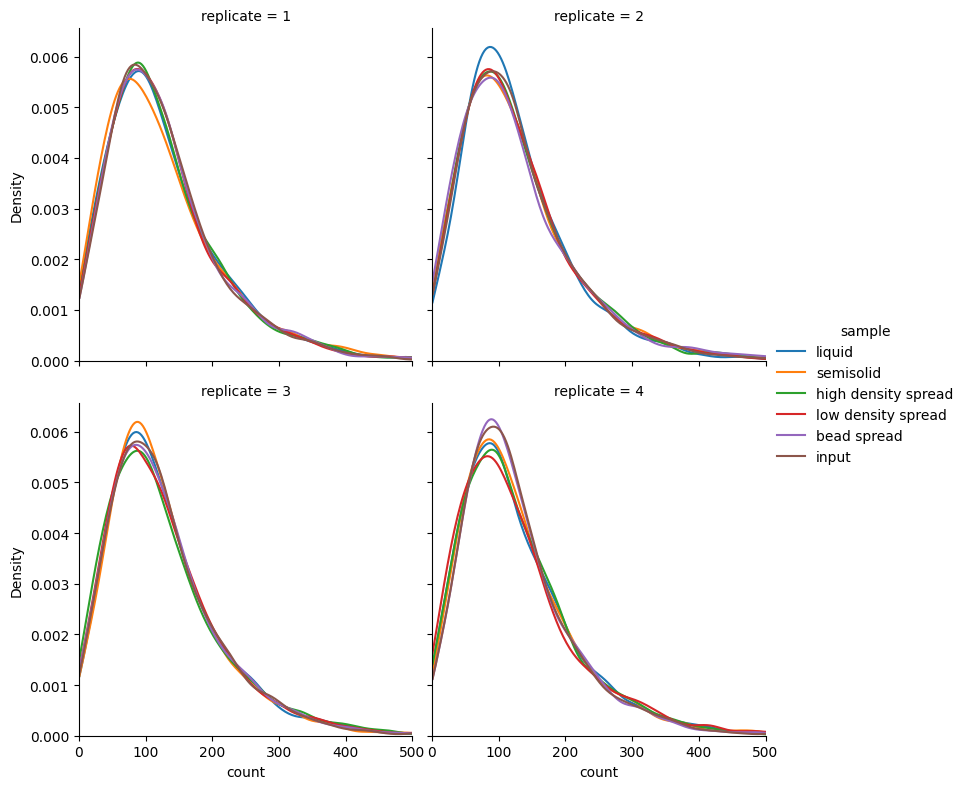

In [17]:
g = sns.FacetGrid(merged_df, col='replicate', hue='sample', col_wrap=2, height=4)
g.map(sns.kdeplot, 'count', clip=[1,500])
plt.xlim([0,500])
g.add_legend()
plt.show()

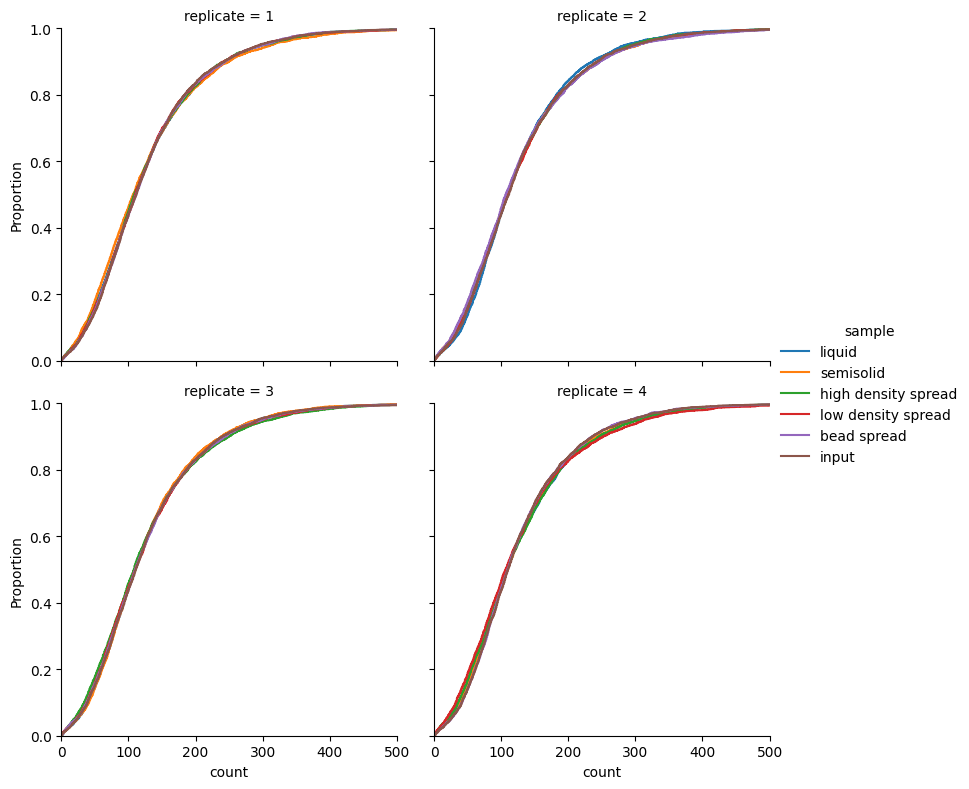

In [18]:
g = sns.FacetGrid(merged_df, col='replicate', hue='sample', col_wrap=2, height=4)
g.map(sns.ecdfplot, 'count')
plt.xlim([0,500])
g.add_legend()
plt.show()

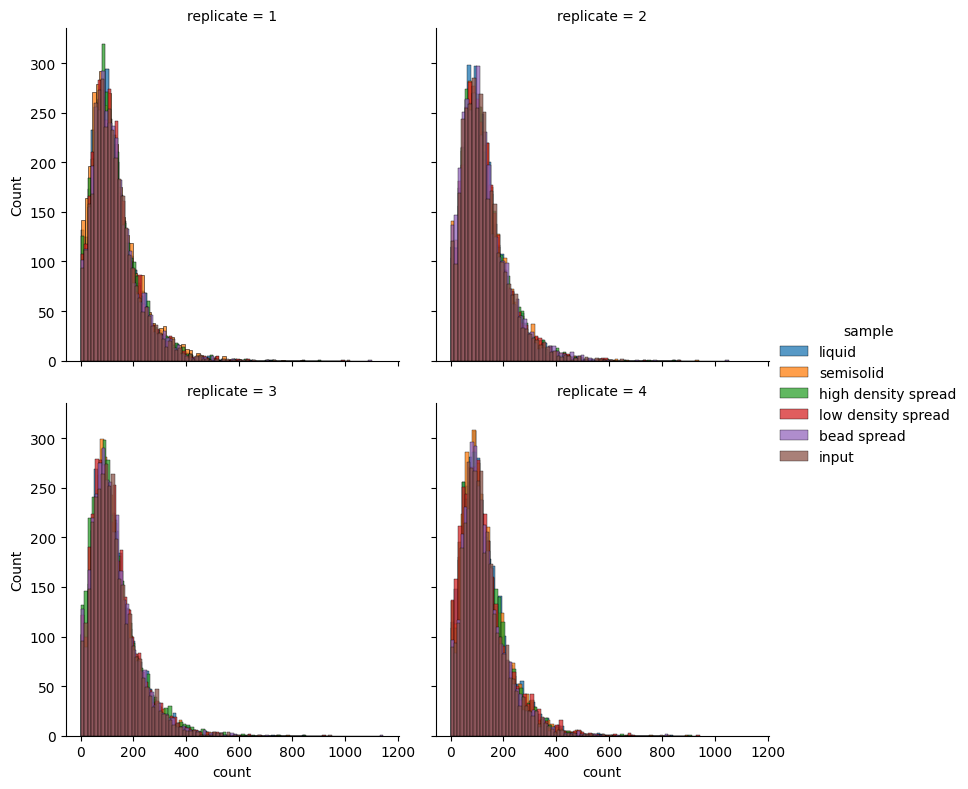

In [19]:
g = sns.FacetGrid(merged_df, col='replicate', hue='sample', col_wrap=2, height=4)
g.map(sns.histplot, 'count')
g.add_legend()
plt.show()

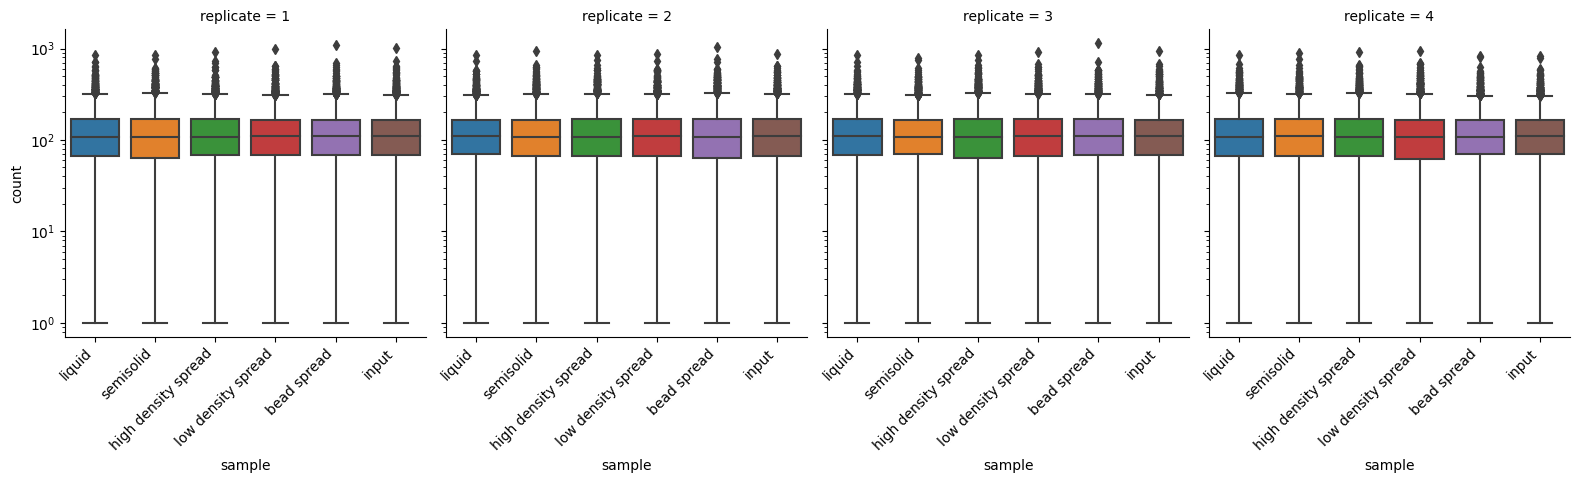

In [20]:
g = sns.catplot(data=merged_df, x="sample", y="count", col='replicate', col_wrap=4, height=4, kind='box')
g.set(yscale="log")
g.set_xticklabels(rotation=45, ha='right')
plt.show()

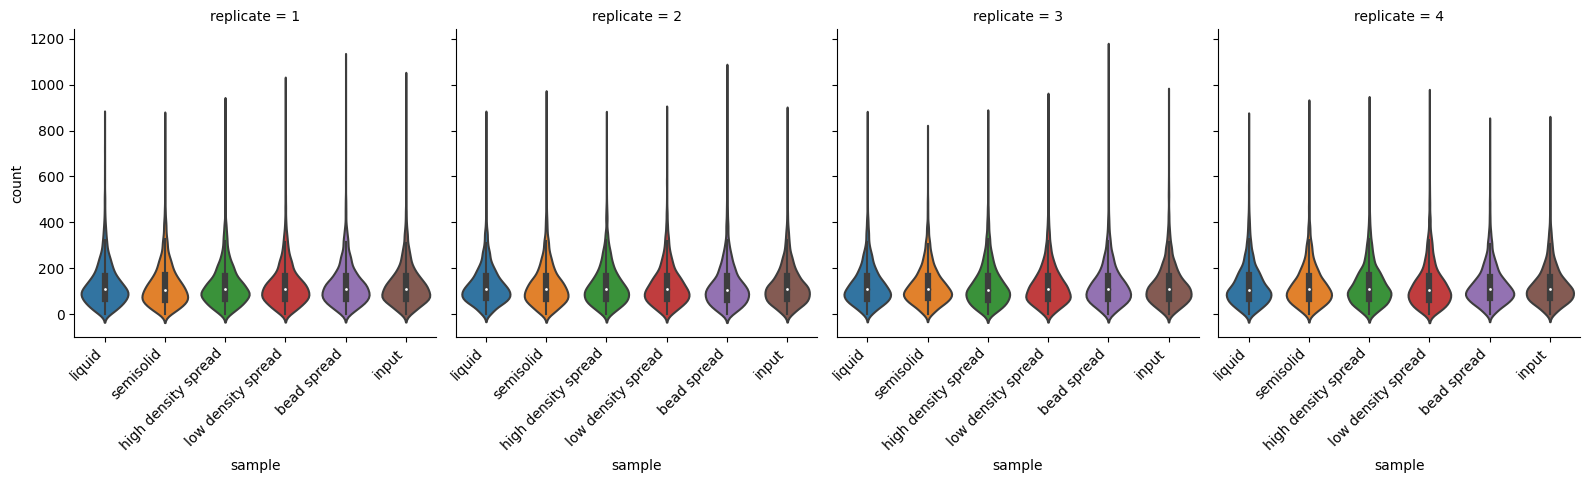

In [21]:
g = sns.catplot(data=merged_df, x="sample", y="count", col='replicate', col_wrap=4, height=4, kind='violin')
g.set_xticklabels(rotation=45, ha='right')
plt.show()

For each replicate, plot correlation between each sample's counts and the input counts. Note that any barcodes not shared between each sample and the input are given a count of 0 for the sample in which they don't appear.

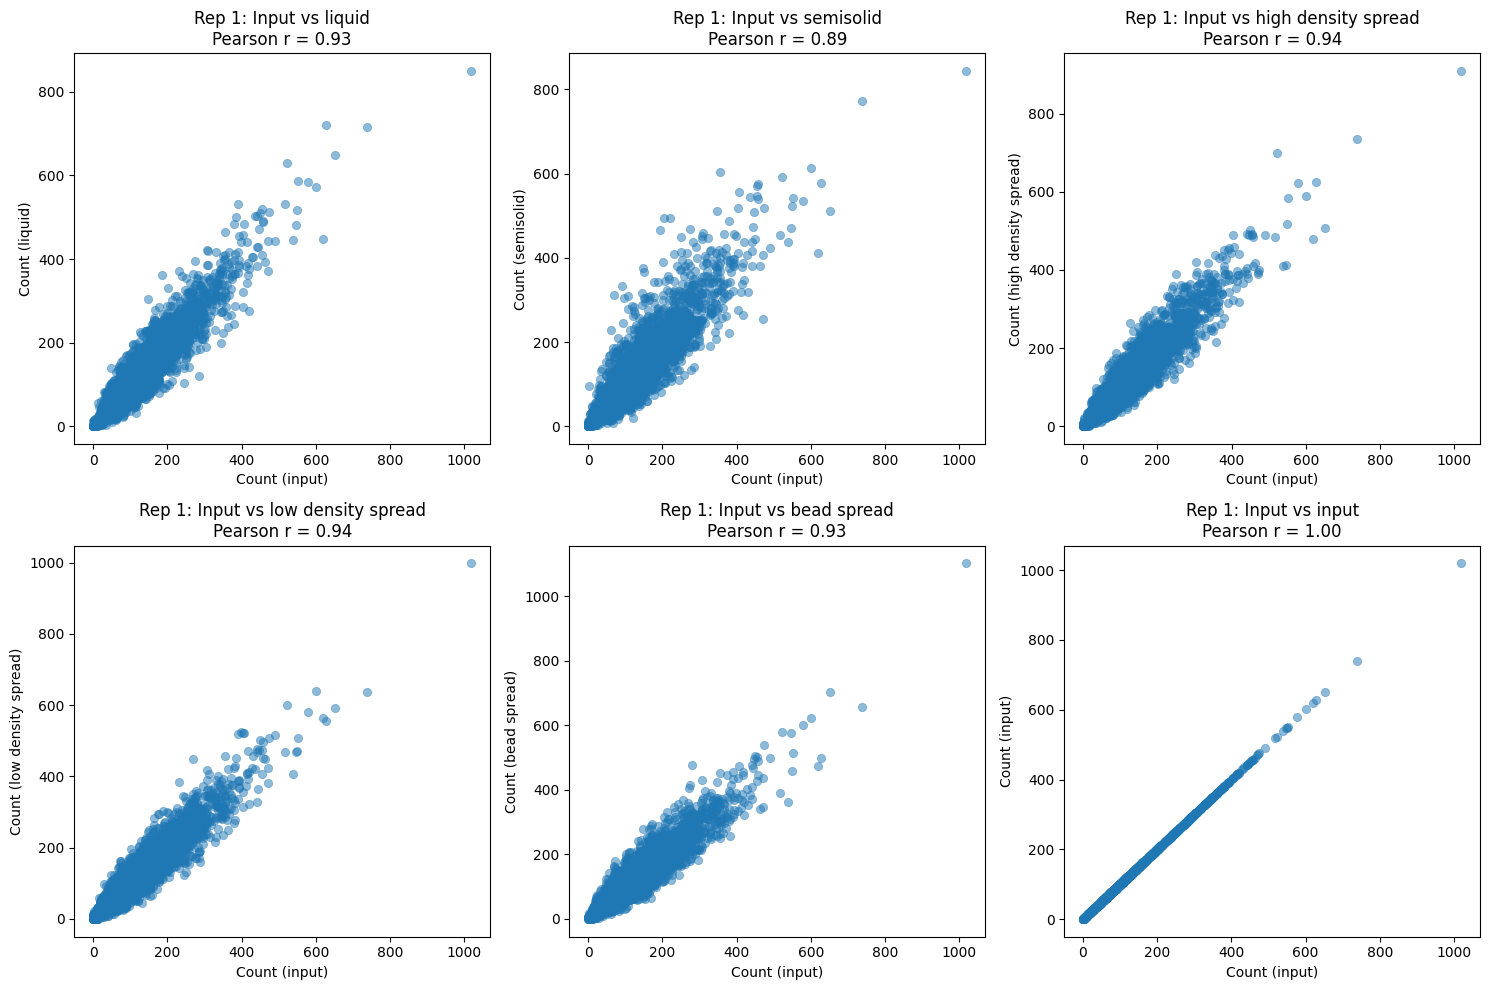

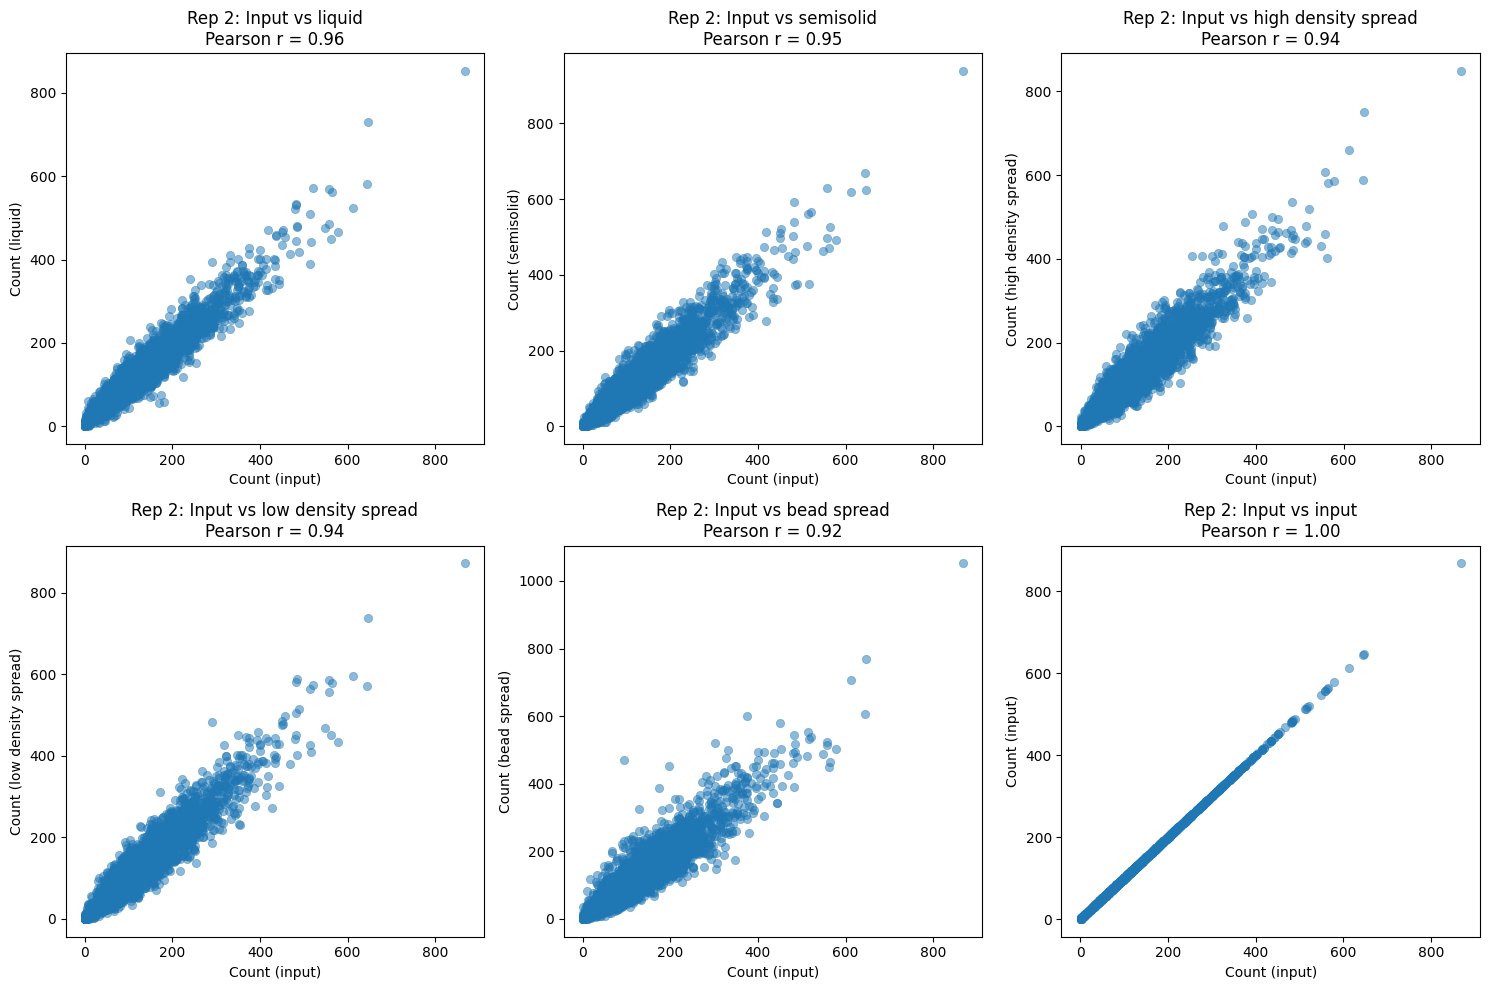

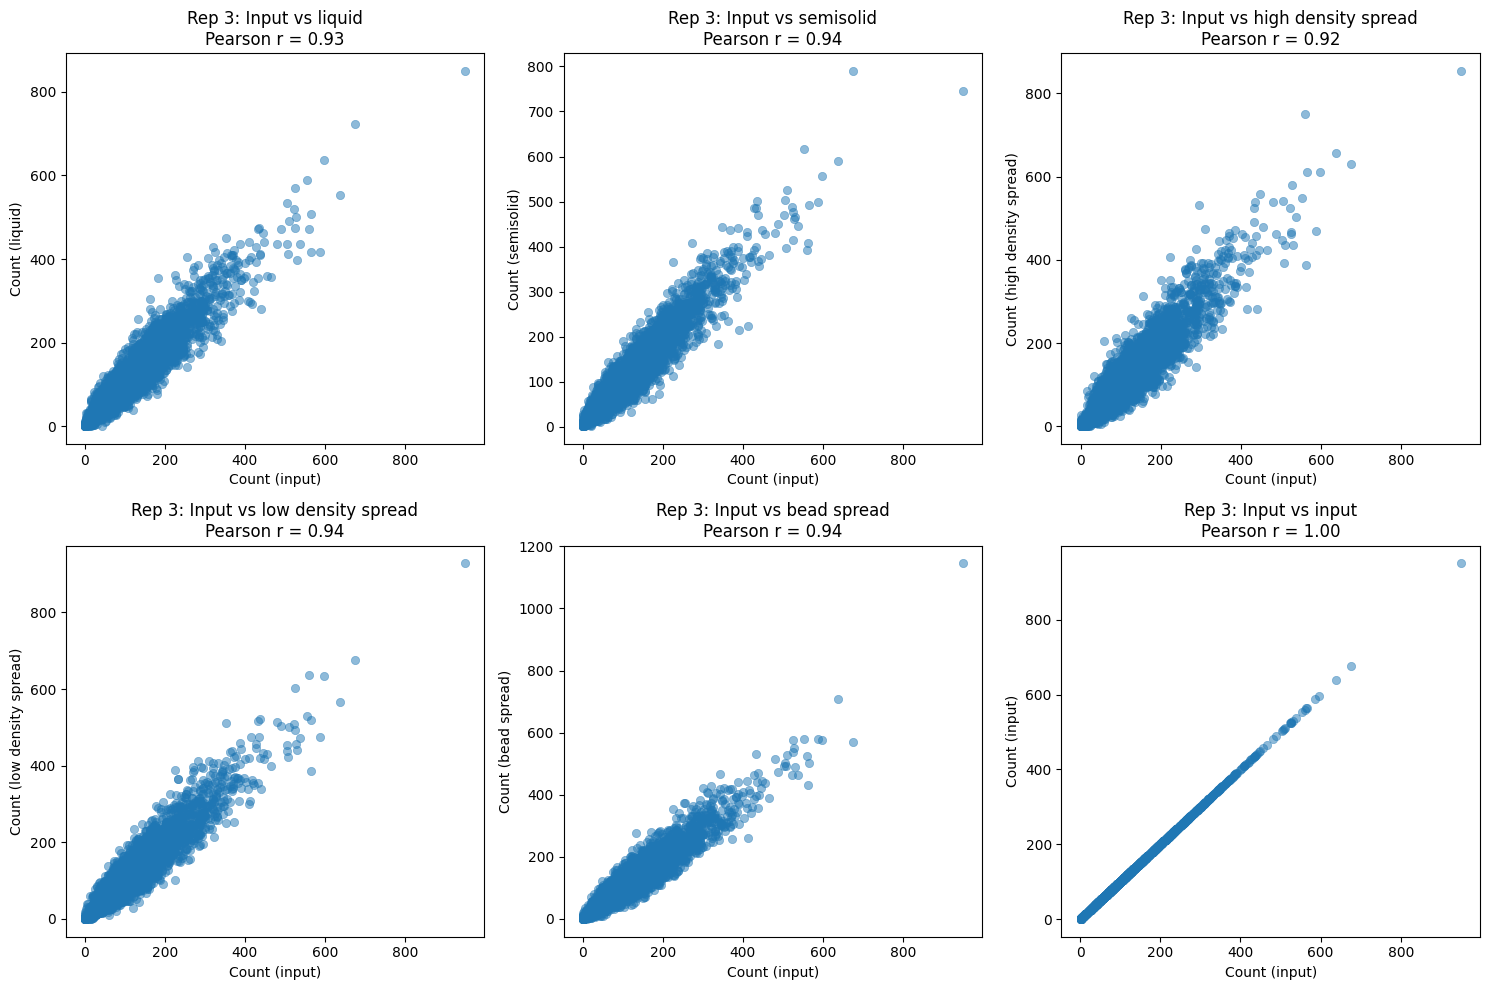

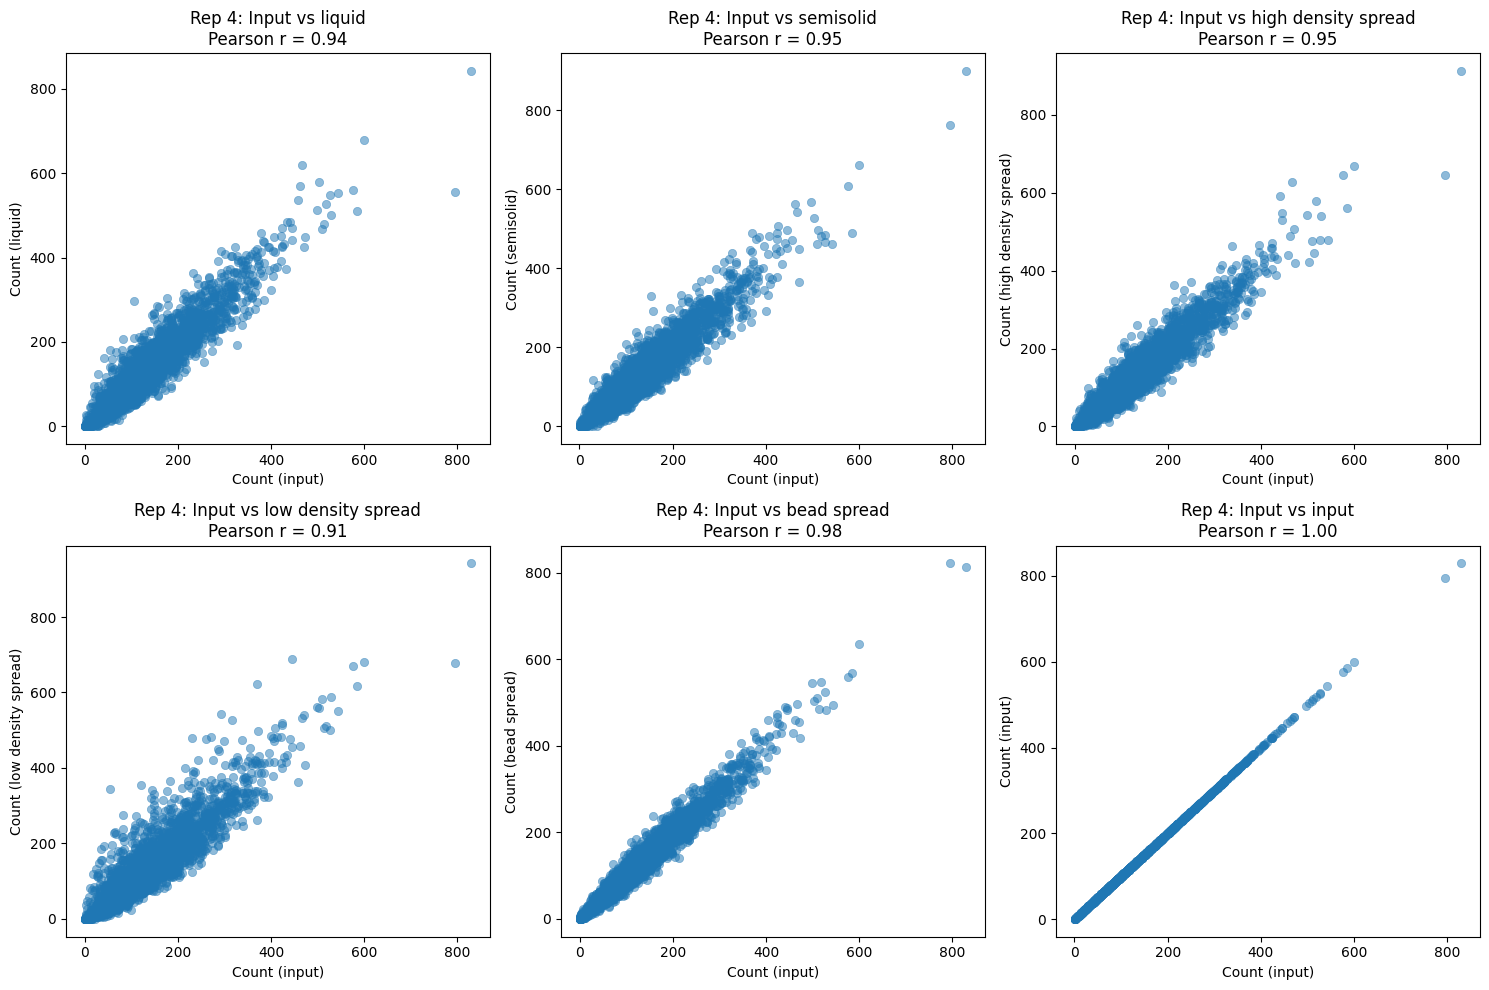

In [30]:
reps = merged_df['replicate'].unique()

for rep in reps:
  rep_df = merged_df[merged_df['replicate'] == rep]
  samples = rep_df['sample'].unique()

  n_cols = 3
  n_rows = 2
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

  for i, sample in enumerate(samples):
    input_df = rep_df[rep_df['sample'] == 'input']
    sample_df = rep_df[rep_df['sample'] == sample]
    input_sample_merged_df = pd.merge(input_df, sample_df, on='sequence', how='outer', suffixes=('_input', f'_{sample}_')).fillna(0)
    
    pearson_corr = stats.pearsonr(input_sample_merged_df['count_input'], input_sample_merged_df[f'count_{sample}_'])[0]
    
    ax = axes[i // n_cols, i % n_cols]
    sns.scatterplot(data=input_sample_merged_df, x='count_input', y=f'count_{sample}_', ax=ax, alpha=0.5, edgecolor=None)
    ax.set_title(f'Rep {rep}: Input vs {sample}\nPearson r = {pearson_corr:.2f}')
    ax.set_xlabel('Count (input)')
    ax.set_ylabel(f'Count ({sample})')

  plt.tight_layout()
  plt.show()

Plot correlation between each input replicate to see what the maximum expected correlation is.

In [36]:
# Pivot df to get a single row per sequence
pivoted_df = merged_df.pivot(index='sequence', columns=['sample', 'replicate'], values='count')
pivoted_df.reset_index(inplace=True)

# Rename columns to remove multi-level index
pivoted_df.columns = [f'{sample}_rep{rep}' if sample != 'sequence' else 'sequence' for sample, rep in pivoted_df.columns]
pivoted_df.head()

# Replace NaNs with 0s
pivoted_df.fillna(0, inplace=True)

# print(pivoted_df.head())
# print(len(pivoted_df))

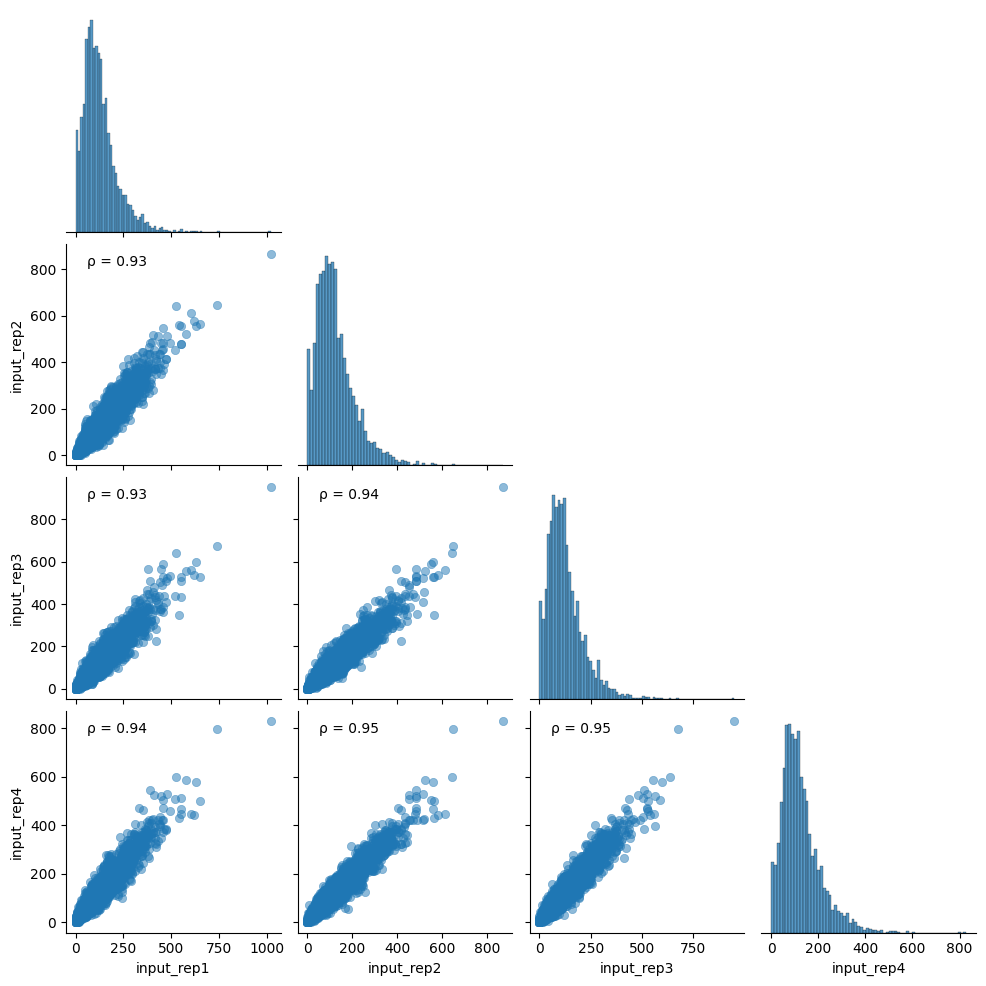

In [46]:
g = sns.pairplot(pivoted_df, vars=['input_rep1', 'input_rep2', 'input_rep3', 'input_rep4'], corner=True, plot_kws={'alpha': 0.5, 'edgecolor': None})

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = stats.pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g.map_lower(corrfunc)
plt.show()

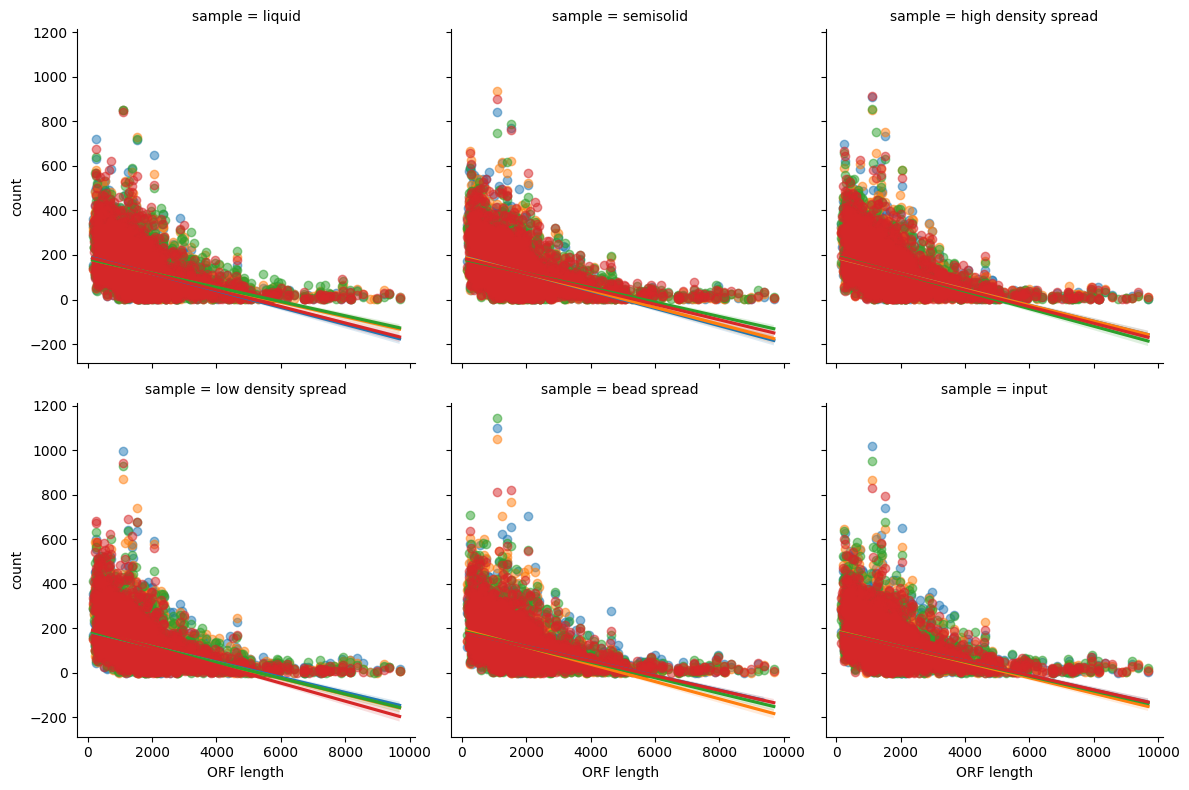

In [67]:
g = sns.FacetGrid(merged_df, col='sample', hue='replicate', col_wrap=3, height=4)
g.map(sns.regplot, 'ORF length', 'count', scatter_kws={'alpha': 0.5, 'edgecolor': None})
plt.show()

There is strong trend toward lower count for larger insert size as expected. Now see if any of the culturing methods make this trend worse when compared to the input counts.

In [70]:
# Create a mapping of sequence to input counts for each replicate
input_counts = merged_df[merged_df['sample'] == 'input'].groupby('replicate').apply(lambda x: x.set_index('sequence')['count'].to_dict())

def calculate_ratio(group):
    rep = group['replicate'].iloc[0]
    rep_input_counts = input_counts.get(rep, {})
    group['log2(fc)'] = np.log2(group['count'] / group['sequence'].map(rep_input_counts))
    return group

ratio_df = merged_df.groupby(['sample', 'replicate'], group_keys=False).apply(calculate_ratio)

ratio_df.head()

,sample,replicate,sequence,count,Name,ORF length,log2(fc)
0,liquid,1,TAGTTGGGAAGGAGAATTCATCTT,850,TFORF2750,1101,-0.261619
1,liquid,2,TAGTTGGGAAGGAGAATTCATCTT,852,TFORF2750,1101,-0.026842
2,liquid,3,TAGTTGGGAAGGAGAATTCATCTT,850,TFORF2750,1101,-0.160465
3,liquid,4,TAGTTGGGAAGGAGAATTCATCTT,842,TFORF2750,1101,0.022448
4,semisolid,1,TAGTTGGGAAGGAGAATTCATCTT,844,TFORF2750,1101,-0.271839


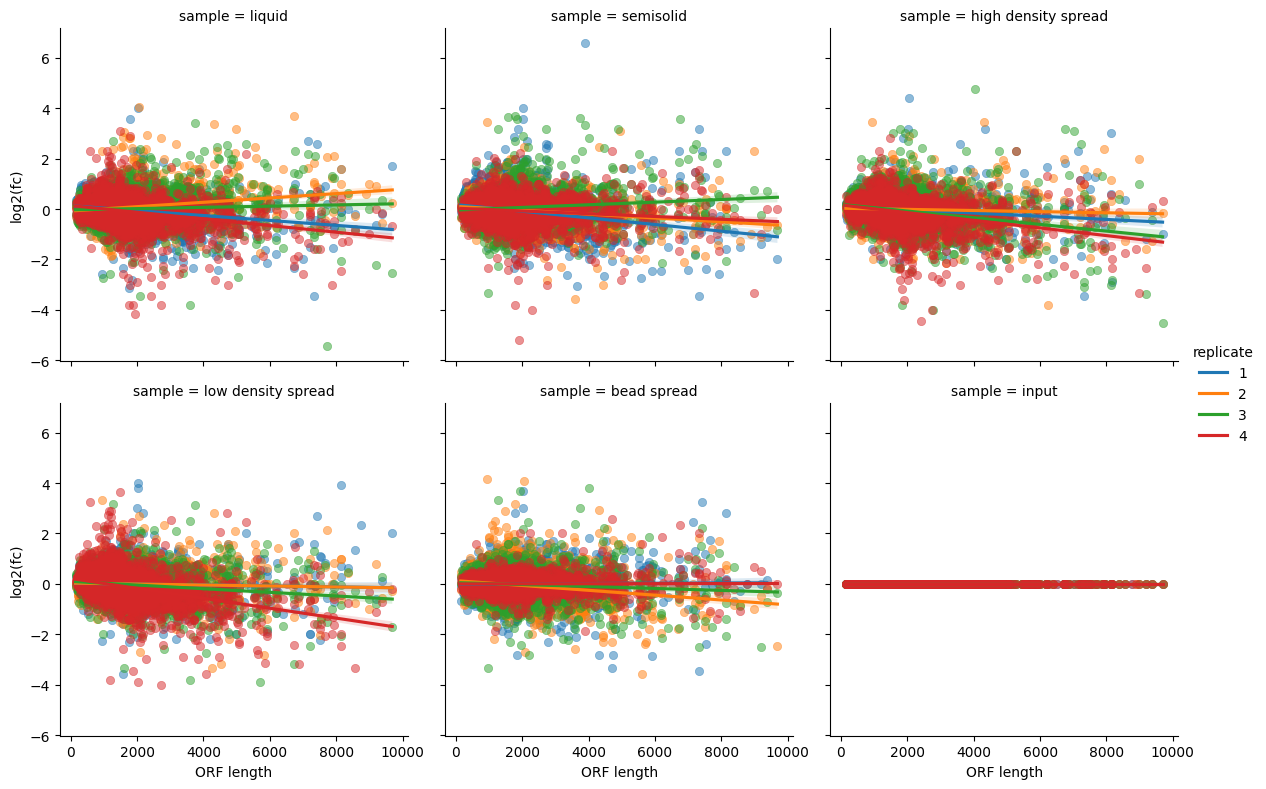

In [72]:
g = sns.FacetGrid(ratio_df, col='sample', hue='replicate', col_wrap=3, height=4)
g.map(sns.scatterplot, 'ORF length', 'log2(fc)', alpha=0.5, edgecolor=None)
g.map(sns.regplot, 'ORF length', 'log2(fc)', scatter=False)
g.add_legend()
plt.show()